# Imports e carregamentos

In [28]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [29]:
df = pd.read_csv('data_live_engineer.csv', encoding='utf-8')

In [30]:
df['result'].value_counts()

result
1    97643
0    97643
Name: count, dtype: int64

# Analisando a importancia das ligas depois da engenharia de características

## Preprocessamento

In [31]:
# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
        ],
        remainder='passthrough'  # Mantém as características categóricas sem transformação
    )
    return preprocessor.fit(X)

# Verificar a presença de valores infinitos (as vezes existem divisões por zero)
print(df.isnull().sum().sum())

0


## Treinando modelo de cada liga

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score

# Lista das ligas únicas no conjunto de dados
leagues = df['league'].unique()

# Dicionário para armazenar histórico de treinamento e avaliação para cada liga
league_histories = {}

# Loop por cada liga para criar, treinar e avaliar um modelo separado
t = len(leagues)
for league in leagues:
    print(f"Treinando modelo para a liga: {league} ({t} ligas restantes)")
    t -= 1
    
    # Filtrando o conjunto de dados para apenas a liga atual
    league_data = df[df['league'] == league]
    
    # Preparando os dados de entrada e saída
    X = league_data.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)
    y = league_data['result']

    preprocessor = create_preprocessor(X)
    X_transformed = preprocessor.transform(X)

    weight_calss_0 = (len(y) - y.sum()) / len(y)
    weight_calss_1 = y.sum() / len(y)

    class_weight = {0: weight_calss_0/2, 1: weight_calss_1*2}

    
    model_randomf = RandomForestClassifier(
                                            n_estimators=100, 
                                            random_state=42, 
                                            min_samples_split=5, 
                                            min_samples_leaf=2, 
                                            # class_weight=class_weight
                                        )
    # Validação cruzada
    cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='roc_auc')
    print(f"Média AUC para {league}: {cv_scores.mean()}")

    # acuracia
    cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='accuracy')
    print(f"Média Acurácia para {league}: {cv_scores.mean()}")

    # Treinando e avaliando o modelo
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model_randomf.fit(X_train, y_train)
    train_auc = roc_auc_score(y_train, model_randomf.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, model_randomf.predict_proba(X_test)[:, 1])

    feature_importance = model_randomf.feature_importances_

    # Armazenando a avaliação em um dicionário
    league_histories[league] = {
        'cv_auc_mean': cv_scores.mean(),
        'train_auc': train_auc,
        'test_auc': test_auc,
        'feature_importance': feature_importance
    }

    # Predicting the values
    y_pred = model_randomf.predict(X_test)
    
    # classification report
    print(classification_report(y_test, y_pred))
    print()

Treinando modelo para a liga: South America - Copa Libertadores (33 ligas restantes)


Média AUC para South America - Copa Libertadores: 0.4770422363199551
Média Acurácia para South America - Copa Libertadores: 0.4247286962195078
              precision    recall  f1-score   support

           0       0.93      0.88      0.91       568
           1       0.89      0.94      0.92       607

    accuracy                           0.91      1175
   macro avg       0.91      0.91      0.91      1175
weighted avg       0.91      0.91      0.91      1175


Treinando modelo para a liga: Asia - AFC Champions League (32 ligas restantes)
Média AUC para Asia - AFC Champions League: 0.4122167131394366
Média Acurácia para Asia - AFC Champions League: 0.40483362909689713
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       542
           1       0.87      0.96      0.91       591

    accuracy                           0.91      1133
   macro avg       0.91      0.90      0.91      1133
weighted avg       0.91      0.91      0.91   

## Avaliando importancia das features de cada liga

## Visualizando média e variância da importância das ligas

In [33]:
dataframe_league = pd.DataFrame.from_dict(league_histories, orient='index')
# dataframe_league.to_csv('dataframe_leagues_avaliation_before_f_engineering.csv', index=False, encoding='utf-8')
dataframe_league

,cv_auc_mean,train_auc,test_auc,feature_importance
South America - Copa Libertadores,0.424729,0.999992,0.968803,"[0.01995640977240333, 0.007091185599308295, 0...."
Asia - AFC Champions League,0.404834,0.999984,0.963953,"[0.020011881682520757, 0.009490078166491323, 0..."
Brazil - Paulista A1,0.406201,0.999990,0.954480,"[0.019704702355628094, 0.006685838716250507, 0..."
South America - Copa Sudamericana,0.390328,0.999983,0.967133,"[0.019465064187068396, 0.007567553629259922, 0..."
Japan - J-League,0.339289,0.999983,0.955671,"[0.018727635460340397, 0.007988791696942107, 0..."
USA - Major League Soccer,0.367862,0.999980,0.956846,"[0.019687268623405637, 0.00924848482280112, 0...."
Mexico - Liga MX,0.379378,0.999981,0.966133,"[0.019132250745270665, 0.007018649497358882, 0..."
Scotland - Premiership,0.408445,0.999986,0.960903,"[0.018404617962996615, 0.0071601543146544155, ..."
Brazil - Serie A,0.356639,0.999996,0.957112,"[0.019854616846158232, 0.006393060489369752, 0..."
France - Ligue 1,0.420292,0.999957,0.961079,"[0.018055908981116045, 0.00673758069831745, 0...."


In [34]:
# We calculate the mean importance for each feature across all leagues
mean_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist()).mean().tolist()

# First, let's convert the list of feature importances into a DataFrame for easier analysis
df_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist())

# Calculating the variance of each feature's importance across all leagues
feature_variances = df_feature_importances.var()

# Creating a summary DataFrame to hold the variance and correlation data
summary_df = pd.DataFrame({
    'Mean Importance': mean_feature_importances,
    'Variance': feature_variances,
})

# Display the summary dataframe sorted by variance to see which features have the most variability across leagues
summary_df.sort_values('Variance', ascending=False, inplace=True)
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Feature'}, inplace=True)

feature_names = df.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1).columns

# Mapeando os números para os nomes das características
summary_df['Feature Name'] = summary_df['Feature'].apply(lambda x: feature_names[x])
summary_df.sort_values('Mean Importance', ascending=False)

,Feature,Mean Importance,Variance,Feature Name
17,43,0.027490,3.098099e-06,timeSinceLastEvent_Home
13,44,0.027390,3.587276e-06,timeSinceLastEvent_Away
22,47,0.025293,2.485954e-06,timeSinceLastEventTotalCards_Home
12,48,0.024726,3.637567e-06,timeSinceLastEventTotalCards_Away
23,36,0.023727,2.463674e-06,defensiveAggression
...,...,...,...,...
21,82,0.002784,2.535252e-06,25ht_away
85,10,0.000651,1.231045e-07,redcards_away
86,9,0.000615,1.164222e-07,redcards_home
87,58,0.000436,6.098785e-08,total_change_redcards_away


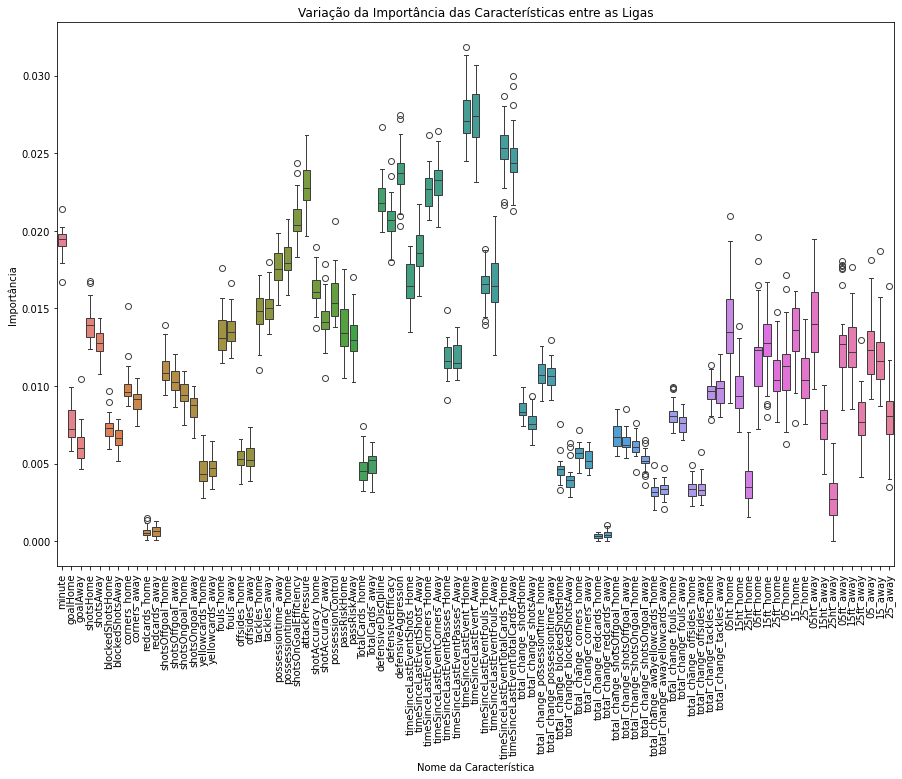

In [35]:
def convert_to_list(ndarray):
    # Verifica se o ndarray não é vazio e converte para lista
    return ndarray.tolist() if ndarray.size else []

importance_lists = dataframe_league['feature_importance'].apply(convert_to_list)

# Criando um DataFrame para armazenar os valores de importância para todas as ligas
feature_importance_df = pd.DataFrame(importance_lists.tolist())

# Calculando estatísticas descritivas para cada característica em todas as ligas
feature_importance_stats = feature_importance_df.describe()

# feature_names = summary_df['Feature Name'].tolist()

# Criar o gráfico de boxplot
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=feature_importance_df)
ax.set_title('Variação da Importância das Características entre as Ligas')
ax.set_xlabel('Nome da Característica')
ax.set_ylabel('Importância')
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90)
plt.show()


- Variação na Importância: Características com boxplots mais largos indicam uma maior variação na sua importância entre as ligas. Isso sugere que o impacto dessas características é mais específico para cada liga. Por outro lado, características com boxplots mais estreitos mostram uma consistência maior, indicando que a importância dessas características é mais uniforme entre as ligas.
Outliers:

- Alguns boxplots têm pontos outliers, que representam ligas onde a importância da característica é notavelmente diferente do padrão observado na maioria das outras ligas. Esses outliers podem indicar casos específicos onde uma característica é particularmente mais ou menos relevante.

- Modelos Personalizados para Ligas: As características com maior variação (boxplots mais largos e/ou com outliers) são fortes candidatas a justificar a criação de modelos separados para cada liga. Isso permitiria que os modelos levassem em conta as peculiaridades de cada liga, resultando em previsões mais precisas.

- Características com menor variação podem ser tratadas de forma mais consistente entre os modelos para diferentes ligas.

## Analisando características com baixa importancia

In [36]:
summary_df.sort_values('Mean Importance', ascending=False)

,Feature,Mean Importance,Variance,Feature Name
17,43,0.027490,3.098099e-06,timeSinceLastEvent_Home
13,44,0.027390,3.587276e-06,timeSinceLastEvent_Away
22,47,0.025293,2.485954e-06,timeSinceLastEventTotalCards_Home
12,48,0.024726,3.637567e-06,timeSinceLastEventTotalCards_Away
23,36,0.023727,2.463674e-06,defensiveAggression
...,...,...,...,...
21,82,0.002784,2.535252e-06,25ht_away
85,10,0.000651,1.231045e-07,redcards_away
86,9,0.000615,1.164222e-07,redcards_home
87,58,0.000436,6.098785e-08,total_change_redcards_away


In [37]:
summary_df.sort_values('Variance', ascending=False)

,Feature,Mean Importance,Variance,Feature Name
0,74,0.011819,9.358067e-06,05ft_home
1,83,0.012764,7.290461e-06,05ft_away
2,80,0.014160,7.274560e-06,05ht_away
3,71,0.013733,7.020026e-06,05ht_home
4,77,0.011075,6.021290e-06,05_home
...,...,...,...,...
84,64,0.003362,2.546769e-07,total_change_awayellowcards_away
85,10,0.000651,1.231045e-07,redcards_away
86,9,0.000615,1.164222e-07,redcards_home
87,58,0.000436,6.098785e-08,total_change_redcards_away


In [38]:
summary_df.to_csv('summary_df.csv', index=False, encoding='utf-8')

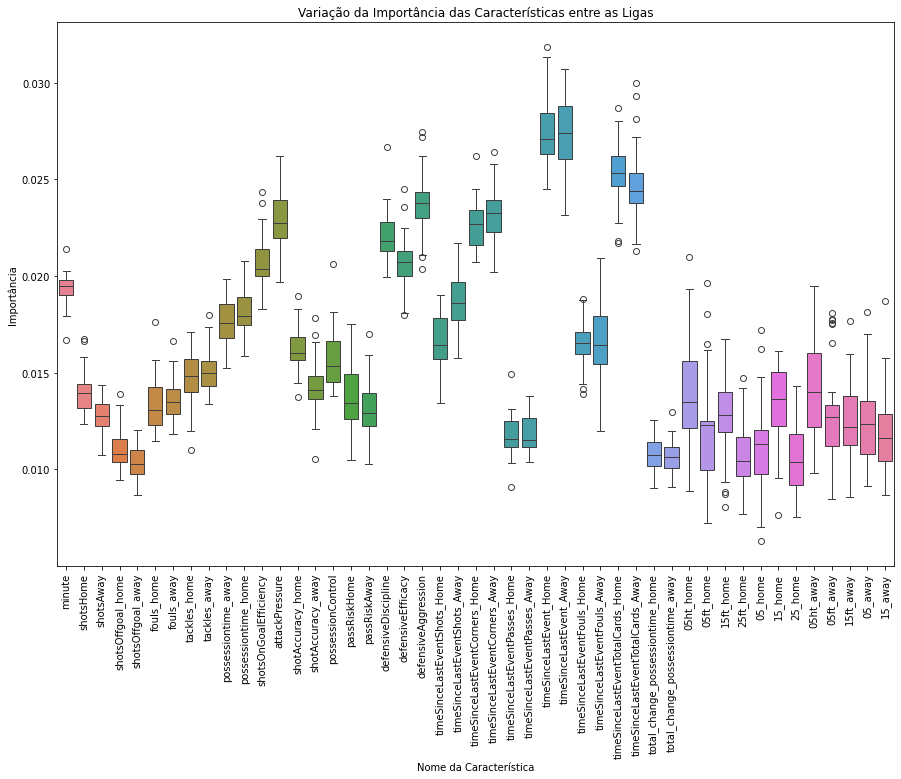

In [39]:
low_importance_features_indices1 = summary_df[summary_df['Mean Importance'] < 0.01 ]['Feature'].tolist()
# low_importance_features_indices2 = summary_df[summary_df['Variance'] > 0.000043]['Feature'].tolist()
# low_importance_features_indices = low_importance_features_indices1 + low_importance_features_indices2
low_importance_features_indices = low_importance_features_indices1 

feature_importance_df_filtered = feature_importance_df.drop(columns=low_importance_features_indices, axis=1)

feature_names_filtered = [feature_names[i] for i in range(len(feature_names)) if i not in low_importance_features_indices]

# Criar o gráfico de boxplot
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=feature_importance_df_filtered)
ax.set_title('Variação da Importância das Características entre as Ligas')
ax.set_xlabel('Nome da Característica')
ax.set_ylabel('Importância')
plt.xticks(ticks=np.arange(len(feature_names_filtered)), labels=feature_names_filtered, rotation=90)
plt.show()


In [40]:
features_to_drop = [feature_names[i] for i in low_importance_features_indices]
features_to_drop

['25_away',
 '25ft_away',
 '15ht_home',
 '25ht_away',
 '15ht_away',
 '25ht_home',
 'corners_home',
 'goalAway',
 'goalHome',
 'TotalCards_home',
 'yellowcards_home',
 'total_change_tackles_away',
 'offsides_away',
 'shotsOngoal_home',
 'shotsOngoal_away',
 'total_change_shotsOffgoal_home',
 'TotalCards_away',
 'total_change_tackles_home',
 'total_change_fouls_home',
 'blockedShotsHome',
 'yellowcards_away',
 'total_change_blockedShotsAway',
 'offsides_home',
 'corners_away',
 'total_change_shotsAway',
 'total_change_blockedShotsHome',
 'total_change_offsides_away',
 'blockedShotsAway',
 'total_change_shotsHome',
 'total_change_fouls_away',
 'total_change_offsides_home',
 'total_change_shotsOffgoal_away',
 'total_change_corners_away',
 'total_change_shotsOngoal_away',
 'total_change_shotsOngoal_home',
 'total_change_awayellowcards_home',
 'total_change_corners_home',
 'total_change_awayellowcards_away',
 'redcards_away',
 'redcards_home',
 'total_change_redcards_away',
 'total_change_re

- Características com Baixa Importância: As características que têm importância média muito baixa e variância alta podem ser excluídas, pois provavelmente não contribuirão significativamente para o modelo ou podem introduzir ruído. 

In [41]:
df = pd.read_csv('data_live_engineer.csv', encoding='utf-8')
df.drop(features_to_drop, axis=1, inplace=True)
df.to_csv("data_live_engineer_filtered.csv", index=False, encoding="utf-8")

In [42]:
df.columns

Index(['minute', 'homeTeam', 'awayTeam', 'shotsHome', 'shotsAway', 'league',
       'shotsOffgoal_home', 'shotsOffgoal_away', 'fouls_home', 'fouls_away',
       'tackles_home', 'tackles_away', 'result', 'match_id',
       'possessiontime_away', 'possessiontime_home', 'shotsOnGoalEfficiency',
       'attackPressure', 'shotAccuracy_home', 'shotAccuracy_away',
       'possessionControl', 'passRiskHome', 'passRiskAway',
       'defensiveDiscipline', 'defensiveEfficacy', 'defensiveAggression',
       'timeSinceLastEventShots_Home', 'timeSinceLastEventShots_Away',
       'timeSinceLastEventCorners_Home', 'timeSinceLastEventCorners_Away',
       'timeSinceLastEventPasses_Home', 'timeSinceLastEventPasses_Away',
       'timeSinceLastEvent_Home', 'timeSinceLastEvent_Away',
       'timeSinceLastEventFouls_Home', 'timeSinceLastEventFouls_Away',
       'timeSinceLastEventTotalCards_Home',
       'timeSinceLastEventTotalCards_Away', 'total_change_possessiontime_home',
       'total_change_possession

In [43]:
# # Função para criar e aplicar o transformador de colunas
# def create_preprocessor(X):
#     numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', StandardScaler(), numeric_features),
#         ],
#         remainder='passthrough'  # Mantém as características categóricas sem transformação
#     )
#     return preprocessor.fit(X)

# # Preparando os dados de entrada e saída
# X = df.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)
# y = df['result']

# preprocessor = create_preprocessor(X)
# X_transformed = preprocessor.transform(X)

# # Salvando o preprocessador para uso futuro
# with open('../models/preprocessor_league.pickle', 'wb') as f:
#     pickle.dump(preprocessor, f)
#     print("Preprocessador salvo em '../models/preprocessor_league.pickle'.")

# # Verificar a presença de valores infinitos (as vezes existem divisões por zero)
# # print(df.replace([np.inf, -np.inf], np.nan).isnull().sum())

# # # Substituir infinitos por NaN e então por um valor numérico ou excluir essas linhas
# # df.replace([np.inf, -np.inf], np.nan, inplace=True)

# # # substituído pelo último valor não-NaN anterior na coluna.
# # df.fillna(method='ffill', inplace=True)

## Treinando modelo de cada liga

In [44]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, roc_auc_score
# from sklearn.model_selection import train_test_split, cross_val_score

# # Lista das ligas únicas no conjunto de dados
# leagues = df['league'].unique()

# # Dicionário para armazenar histórico de treinamento e avaliação para cada liga
# league_histories = {}

# # Loop por cada liga para criar, treinar e avaliar um modelo separado
# t = len(leagues)
# for league in leagues:
#     print(f"Treinando modelo para a liga: {league} ({t} ligas restantes)")
#     t -= 1
    
#     # Filtrando o conjunto de dados para apenas a liga atual
#     league_data = df[df['league'] == league]
    
#     # Preparando os dados de entrada e saída
#     X = league_data.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)
#     y = league_data['result']

#     preprocessor = create_preprocessor(X)
#     X_transformed = preprocessor.transform(X)

#     weight_calss_0 = (len(y) - y.sum()) / len(y)
#     weight_calss_1 = y.sum() / len(y)

#     class_weight = {0: weight_calss_0/2, 1: weight_calss_1*2}

    
#     model_randomf = RandomForestClassifier(
#                                             n_estimators=100, 
#                                             random_state=42, 
#                                             min_samples_split=5, 
#                                             min_samples_leaf=2, 
#                                             class_weight=class_weight
#                                         )
#     # Validação cruzada
#     cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='roc_auc')
#     print(f"Média AUC para {league}: {cv_scores.mean()}")

#     # acuracia
#     cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='accuracy')
#     print(f"Média Acurácia para {league}: {cv_scores.mean()}")

#     # Treinando e avaliando o modelo
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#     model_randomf.fit(X_train, y_train)
#     train_auc = roc_auc_score(y_train, model_randomf.predict_proba(X_train)[:, 1])
#     test_auc = roc_auc_score(y_test, model_randomf.predict_proba(X_test)[:, 1])

#     feature_importance = model_randomf.feature_importances_

#     # Armazenando a avaliação em um dicionário
#     league_histories[league] = {
#         'cv_auc_mean': cv_scores.mean(),
#         'train_auc': train_auc,
#         'test_auc': test_auc,
#         'feature_importance': feature_importance
#     }

#     # Predicting the values
#     y_pred = model_randomf.predict(X_test)
    
#     # classification report
#     print(classification_report(y_test, y_pred))
#     print()